# INM706 Deep Learning for Sequence Analysis
### Sarah Rhalem (190051884) & Stelios Kliafas (########)

Draft Notes/ Working comments:
Dataset >> Problem +Evaluation Metric >> Model

In [2]:
#!pip install transformers
#!pip install sacrebleu

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import json
import torch
import re
import numpy as np
import pandas as pd
import csv
import random
import time
import random
import datasets
from tqdm.notebook import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW, get_linear_schedule_with_warmup

In [2]:
# Set to use GPU on device if available:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\INM706\\INM706_DL_Sequence_Analysis'

In [4]:
# Load csv dataset, create listing column
raw_dataset_df= pd.read_csv(os.path.join("Data\\netflix_titles.csv") , encoding="utf8")
raw_dataset_df["listing"]= raw_dataset_df["listed_in"].str.split(pat=",", n=1).str.get(0)

# Cleanse Data
raw_dataset_df["description"].isna().sum() # Check null entries for description - None
raw_dataset_df["plot_description"]=raw_dataset_df["description"].map(lambda x: re.sub( r'"', '', x)) #remove quotation marks



In [5]:
raw_dataset_df["description"].to_list()[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

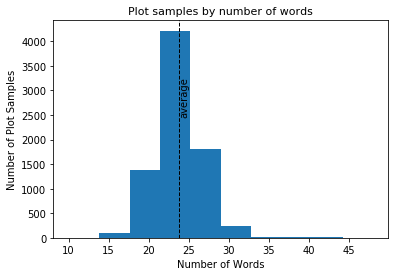

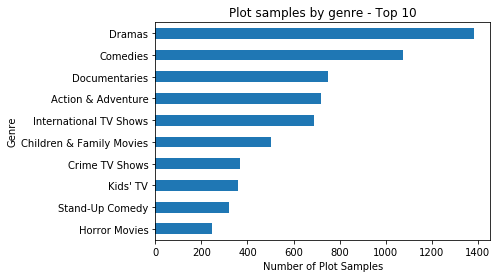

In [6]:
# Exploratory Data Analysis for the Netflix Plot Dataset

# Maximum length of plot description is < 45 words. Max length of generation will be set to ~50 
raw_dataset_df['Number_of_words'] = raw_dataset_df.description.apply(lambda x: len(str(x).split(' ')))
x=raw_dataset_df['Number_of_words']
plt.hist(raw_dataset_df['Number_of_words'])
plt.title("Plot samples by number of words", fontsize=11)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(x.mean() ,2500 ,'average',rotation=90)
plt.xlabel('Number of Words')
plt.ylabel('Number of Plot Samples')
#plt.savefig(os.path.join(path, r'XXXXXXX.jpg'), dpi=300, bbox_inches='tight')
plt.show()

# Plots by genre (top 10) - will map all genres to top 10 genres
#genre_count= raw_dataset_df['listing'].value_counts()
raw_dataset_df.listing.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title("Plot samples by genre - Top 10")
plt.xlabel("Number of Plot Samples")
plt.ylabel('Genre')
plt.show()

In [7]:
# Map each data sample listing to a generic genre
 
 # Identify the show listings for mapping to summarised genres
raw_dataset_df.listing.value_counts()

# map show listing to a specific genre. Note: Listing types with under ~100 data samples are classified under the genre "Other"
genre_mapping= { "romance": {"Romantic TV Shows", "Romantic Movies"} ,
                "drama": {"Dramas", "TV Dramas"}  ,
                 "comedy": {"Comedies", "Stand-Up Comedy", "TV Comedies", "Stand-Up Comedy & Talk Shows"},
                 "documentary": {"Documentaries", "Docuseries"},
                 "action": {"Action & Adventure", "TV Action & Adventure"} ,
                 "international": {"International TV Shows", "International Movies", "Spanish-Language TV Shows"},
                 "children": {"Children & Family Movies", "Kids' TV"},
                 "crime": {"Crime TV Shows"},
                 "horror": {"Horror Movies", "TV Horror"} ,
                 "anime" : {"Anime Series", "Anime Features"},
                 "other" : {"Thrillers", "British TV Shows", "Reality TV", "Classic & Cult TV", "TV Shows", "TV Sci-Fi & Fantasy",
                         "Classic Movies", "Movies", "Independent Movies", "Cult Movies", "Sports Movies", "LGBTQ Movies", "Music & Musicals",
                         "Sci-Fi & Fantasy"} }

# function to map listings to genres by dictionary key
def map_function(dictionary):
    def my_map(x):
        res = ""
        for key in dictionary.keys():
            if (x in dictionary[key]):
                res = key
                break
        return res
    return my_map

# Add genre column based on listing mapping
raw_dataset_df["genre"] = raw_dataset_df["listing"].map(map_function(genre_mapping))

# Write to txt file
plot_dataset_df= raw_dataset_df[["genre","plot_description"]].copy()
plot_dataset= plot_dataset_df.to_csv('Data\\netflix_plot_dataset.txt', index=False, header=None, sep=":", doublequote=False )

# Sense check - view data header and check all descriptions were mapped
print(plot_dataset_df.head())
print(plot_dataset_df.genre.unique())

           genre                                   plot_description
0  international  In a future where the elite inhabit an island ...
1          drama  After a devastating earthquake hits Mexico Cit...
2         horror  When an army recruit is found dead, his fellow...
3         action  In a postapocalyptic world, rag-doll robots hi...
4          drama  A brilliant group of students become card-coun...
['international' 'drama' 'horror' 'action' 'crime' 'documentary' 'other'
 'comedy' 'anime' 'children' 'romance']


In [8]:
 # Load model and Tokenizer
configuration = GPT2Config.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

configuration.pad_token_id = configuration.eos_token_id
tokenizer.pad_token = tokenizer.eos_token


special_tokens_dict = {
                "bos_token": "<genre>",
                 "sep_token":"<plot>",
                 "unk_token": "<unknown>"
            }

num_of_toks= tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_of_toks, 'tokens')

We have added 2 tokens


In [9]:

#tokenizer.convert_tokens_to_string(50259)

test1=tokenizer.convert_ids_to_tokens(50257)

tokenizer.convert_tokens_to_string(test1)



'<genre>'

In [10]:
# Dataset Class
class NetflixPlotDataset(Dataset):
          def __init__(self, tokenizer=tokenizer, dataset_path=os.path.join("Data\\netflix_plot_dataset.txt"), block_size=50): 

            bos_tkn= tokenizer.bos_token
            sep_tkn= tokenizer.sep_token
            eos_tkn= tokenizer.eos_token
            
            test_file = open(os.path.join(dataset_path), encoding="utf-8")
            lines =[]
            for line in test_file.read().splitlines():
                if (len(line) > 0 and not line.isspace()):
                    try:
                        lines+= [bos_tkn+line[:line.index(':')]+sep_tkn+line[line.index(':')+1:]+ eos_tkn]
                    except ValueError:
                        raise ValueError('line '+line+' does not contain ":"')
            
            self.input_ids = tokenizer.batch_encode_plus(lines, add_special_tokens=True, max_length=block_size, truncation=True, padding='max_length')["input_ids"] 

        
          def __len__(self):
            return len(self.input_ids)

          def __getitem__(self, i):
            return torch.tensor(self.input_ids[i], dtype=torch.long)
        

In [11]:
# Instantiate dataset and return length
dataset=NetflixPlotDataset()
dataset.__len__()

7786

In [12]:
# Example of decoded tokenizer data sample
tokenizer.decode(dataset[23])

'<genre> drama <plot> When a middle-aged divorcee returns to Kolkata to visit his ailing father, long-buried memories resurface, bringing new discoveries with them.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [13]:
# Set batch size

BATCH_SIZE=10

def split_datasets_and_create_dataloaders(dataset, seed=10, batch_size=BATCH_SIZE):
  
    train_len= int(0.7 * len(dataset))
    val_len= int(0.2* len(dataset))
    test_len= int(len(dataset)-(train_len + val_len))
    
    lengths=[train_len, val_len, test_len]
                              
    train_subset, val_subset, test_subset = random_split(dataset, lengths, torch.Generator().manual_seed(seed))
                              
    print("Number of Training samples:", len(train_subset))
    print("Number of Validation samples:", len(val_subset))
    print("Number of Testing samples:", len(test_subset))

    train_dataloader = DataLoader(
              train_subset,
              batch_size = batch_size,
              shuffle = True
          )

    val_dataloader = DataLoader(
              val_subset,
              batch_size = batch_size,
              shuffle = False
          )
    
    test_dataloader = DataLoader(
              test_subset,
              batch_size = batch_size,
              shuffle = False
          )
  
    dataloaders = {'train_dataloader': train_dataloader, 'val_dataloader': val_dataloader,'test_dataloader': test_dataloader}
    
    return dataloaders

In [14]:
def save_checkpoint(state, checkpoint_path):
    print("Saving checkpoint ... ")
    torch.save(state, checkpoint_path)
    print("Checkpoint:", checkpoint_path, "saved.")


def load_checkpoint(model, optimizer, scheduler, load_checkpoint_path):
    print("Loading checkpoint ... ")
    checkpoint = torch.load(load_checkpoint_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, scheduler, start_epoch

In [15]:
def format_time(start_time,end_time):
    hours, remainder = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return ("{:0>2}:{:0>2}:{:0>2}".format(int(hours), int(minutes), int(seconds)))

def set_seed():
    random.seed(10)
    np.random.seed(10)
    torch.manual_seed(10)
    torch.cuda.manual_seed_all(10)

In [16]:

# load Dataloaders
BATCH_SIZE=10
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=BATCH_SIZE)

# Training/Validation method

def train_val(model, dataloaders, starting_epoch, optimizer, scheduler, epochs, device):
    print("\n\n" + "-" * 15)
    print("| TRAINING... |")
    print("-" * 15)
    set_seed()
    start_training_time = time.time()
    
    train_loss_history=[]
    val_loss_history=[]
    train_perplexity_history=[]
    val_perplexity_history=[]
    

    for epoch in range(starting_epoch, epochs): 
        train_loss=0
        model.train()     
        for step, batch in tqdm(enumerate(dataloaders['train_dataloader']), total=len(dataloaders['train_dataloader'])):
                input_ids = batch.to(device)
                model.zero_grad()        
                outputs = model(input_ids, labels=input_ids)
                
                loss = outputs[0]
                batch_loss = loss.item()  
                train_loss += batch_loss
                
                if step % 200 == 199:
                    print("Epoch:",epoch+1, "/", epochs, "Batch:", step+1, "/", len(dataloaders['train_dataloader']), "Loss", train_loss/200) 
                    train_loss=0.0

                model.eval()
                if step % 100 == 0 and step != 0:
                        samples = model.generate( #decoder_start_token_id=50258,
                                                bos_token_id=50257,
                                                do_sample=True,   
                                                top_k=50,
                                                max_length = 50,
                                                min_length = 15,
                                                top_p = 0.95,
                                                num_return_sequences=1,
                                                repition_penalty=1.1,
                                                no_repeat_ngram_size = 2,
                                                temperature=1.1
                                            )

                        for i, sample in enumerate(samples):
                                  print("{}".format(tokenizer.decode(sample, skip_special_tokens=False)))

                model.train()
                

                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                torch.cuda.empty_cache()
                
        end_epoch_time = time.time()
        epoch_train_loss = train_loss / len(dataloaders['train_dataloader'])
        epoch_train_perplexity= torch.exp(torch.tensor(epoch_train_loss))     
        epoch_train_time = format_time(start_training_time, end_epoch_time)
        train_loss_history.append(epoch_train_loss)
        train_perplexity_history.append(epoch_train_perplexity)
        
        print(f' epoch: {epoch + 1}, train loss: {epoch_train_loss:.6f}, train ppl: {epoch_train_perplexity:.6f}, train time:{epoch_train_time}')


        print("Validating...")

        start_val_time = time.time()
        model.eval()
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for step, batch in tqdm(enumerate(dataloaders['val_dataloader']),total=len(dataloaders['val_dataloader'])):        
                        input_ids = batch[0].to(device)
                        outputs  = model(input_ids, labels=input_ids)          
                        loss = outputs[0]
                        # loss, logits= outputs[:2]
                        batch_loss = loss.item()  
                        val_loss += batch_loss
                        
                        torch.cuda.empty_cache()
                        end_val_time = time.time()
            
        epoch_val_time = format_time(start_val_time, end_val_time)
        epoch_val_loss = val_loss/ len(dataloaders['val_dataloader'])
        epoch_val_perplexity= torch.exp(torch.tensor(epoch_val_loss))
        val_loss_history.append(epoch_val_loss)
        val_perplexity_history.append(epoch_val_perplexity)
        #print("Validation time: ", epoch_val_time)  

        print(f' epoch: {epoch +1}, val loss: {epoch_val_loss:.6f}, val ppl: {epoch_val_perplexity:.6f}, val_time: {epoch_val_time}')
          
        performance_history = {}
        performance_history['train_loss']=train_loss_history
        performance_history['val_loss']=val_loss_history
        performance_history['train_perplexity']=train_perplexity_history
        performance_history['val_perplexity']=val_perplexity_history
        
        if epoch == epochs-1:
            checkpoint = {
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),
              'performance_history': performance_history,
              'epoch': epoch + 1,
              }
            save_checkpoint(checkpoint, f"./checkpoint_{checkpoint['epoch']}.pth.tar")
        print("")
        print("Training Finished")
        

    return performance_history

Number of Training samples: 5450
Number of Validation samples: 1557
Number of Testing samples: 779


In [19]:
# Instantiate model, apply resizing for token embeddings - re-run instantiation before training
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

#Hyperparameters
EPOCHS=10
DEVICE='cuda:0'
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


# Run train_val
#Test_1= train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=DEVICE)



In [23]:
from matplotlib.ticker import MaxNLocator
# Methods to plot training results
def plot_train_val_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_loss'])+1)
    plt.plot(epoch_count, (history['train_loss']), label='Training Loss')
    plt.plot(epoch_count, (history['val_loss']), label='Validation Loss')
    plt.ylim(0,2.5)
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_train_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_loss'])+1)
    plt.plot(epoch_count, (history['train_loss']), label='Training Loss')
    plt.ylim(0,1)
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_val_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['val_loss'])+1)
    plt.plot(epoch_count, (history['val_loss']), label='Validation Loss')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig

def plot_train_val_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_perplexity'])+1)
    plt.plot(epoch_count, (history['train_perplexity']), label='Train perplexity')
    plt.plot(epoch_count, (history['val_perplexity']), label='Validation perplexity')
    plt.xticks(epoch_count)
    plt.ylim(0,12)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_train_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_perplexity'])+1)
    plt.plot(epoch_count, (history['train_perplexity']), label='Train perplexity')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_val_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['val_perplexity'])+1)
    plt.plot(epoch_count, (history['val_perplexity']), label='Validation perplexity')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig

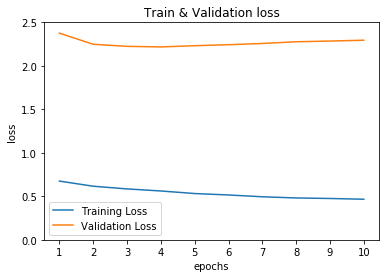

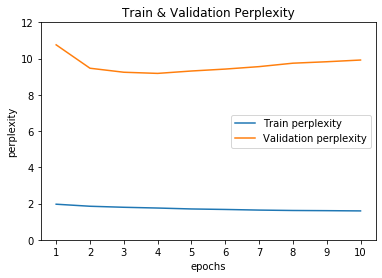

In [26]:
fig= plot_train_val_loss(Test_1, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_10eps_crop.jpg')

fig= plot_train_val_perplexity(Test_1, "Train & Validation Perplexity");
#fig.savefig(r'Figures\\train_val_perplexity_10eps_crop.jpg')

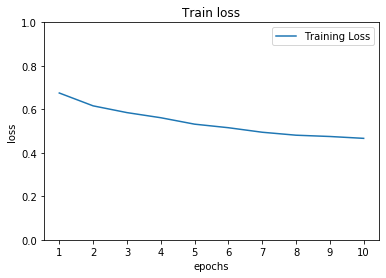

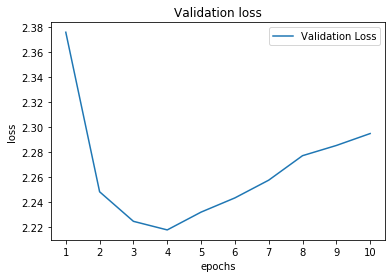

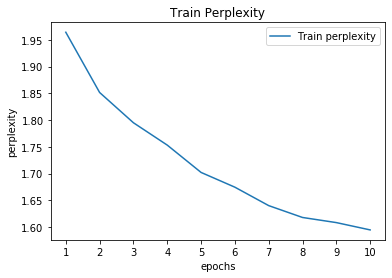

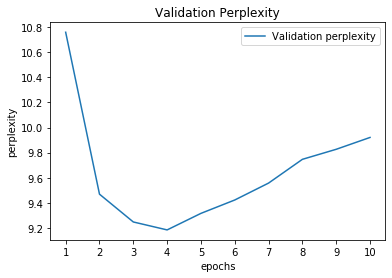

In [27]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_1, "Train loss");
#fig.savefig(r'Figures\\train_loss_10eps.jpg')

fig= plot_val_loss(Test_1, "Validation loss");
#fig.savefig(r'Figures\\val_loss_10eps.jpg')

fig= plot_train_perplexity(Test_1, "Train Perplexity");
#fig.savefig(r'Figures\\train_perplexity_10eps.jpg')

fig= plot_val_perplexity(Test_1, "Validation Perplexity");
#fig.savefig(r'Figures\\val_perplexity_10eps.jpg')


In [28]:
Test_1

{'train_loss': [0.6751095924902399,
  0.6160350421153077,
  0.5849798248448503,
  0.5614123114752113,
  0.531816329649829,
  0.5154687634301842,
  0.494664918610809,
  0.48105061251089115,
  0.4751082656580374,
  0.46655934075696753],
 'val_loss': [2.3758059487893033,
  2.247972560998721,
  2.2242939449273624,
  2.2174123311654115,
  2.2316775421301522,
  2.2430607775847116,
  2.257274412191831,
  2.2768959280772085,
  2.285072686580511,
  2.294637122979531],
 'train_perplexity': [tensor(1.9642),
  tensor(1.8516),
  tensor(1.7950),
  tensor(1.7531),
  tensor(1.7020),
  tensor(1.6744),
  tensor(1.6399),
  tensor(1.6178),
  tensor(1.6082),
  tensor(1.5945)],
 'val_perplexity': [tensor(10.7597),
  tensor(9.4685),
  tensor(9.2470),
  tensor(9.1835),
  tensor(9.3155),
  tensor(9.4221),
  tensor(9.5570),
  tensor(9.7464),
  tensor(9.8264),
  tensor(9.9208)]}

#### EVALUATION IN PROGRESS (NEED TO WORK ON MORE):

In [20]:
# Instantiate model, apply resizing for token embeddings - re-run instantiation before training
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

EPOCHS=10
DEVICE='cuda:0'
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


def load_checkpoint(model, optimizer, scheduler, load_checkpoint_path):
    print("Loading checkpoint ... ")
    checkpoint = torch.load(load_checkpoint_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, scheduler, start_epoch

load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "checkpoint_10.pth.tar")

Loading checkpoint ... 


C:\Users\sarah\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:234: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(GPT2LMHeadModel(
   (transformer): GPT2Model(
     (wte): Embedding(50259, 768)
     (wpe): Embedding(1024, 768)
     (drop): Dropout(p=0.1, inplace=False)
     (h): ModuleList(
       (0): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
         )
         (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (mlp): MLP(
           (c_fc): Conv1D()
           (c_proj): Conv1D()
           (dropout): Dropout(p=0.1, inplace=False)
         )
       )
       (1): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
  

In [21]:
def generate_text(num_samples,input_genres=None):
    
    # Generate samples based on Top-k and Top-p filtering and sampling
    
   # set_seed()
    generated_plots=[]
    model.eval()
    with torch.no_grad():
        
        bos_tkn=tokenizer.bos_token
        sep_tkn=tokenizer.sep_token
        eos_tkn=tokenizer.eos_token

        # Input prompt for text generation is a randomly selected genre from our genre list.
        genre_list=["romance", "drama", "comedy", "documentary", "action", "international",
                   "children", "crime", "horror", "anime", "other"]

        for i in range (num_samples):
                if(input_genres is None):
                    genre= random.choice(genre_list)
                else:
                    genre = input_genres[i]
                    
                prompt= bos_tkn + genre + ": " + sep_tkn  
                prompts= (torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)).to(device)

                samples= model.generate(prompts,
                                        do_sample=True,   
                                        top_k=50,
                                        min_length=15,
                                        max_length = 50,
                                        top_p = 0.95,
                                        num_return_sequences=1,
                                        repitition_penalty=1.1,
                                        no_repeat_ngram_size = 2,
                                        temperature=1.1
                                    )

                #for i, sample in enumerate(samples):

                generated_plot= "{}".format(tokenizer.decode(samples[0], skip_special_tokens=True, ))
                #print(len(samples))
                #print(generated_plot)
                generated_plots.append(generated_plot)
        
    return generated_plots



In [22]:
#Evaluates the test dataset on the fine-tuned model and generates samples from the model to determine BLEU Score.

def test_generate(model, dataloaders, device):
    model.eval()
    metric= datasets.load_metric('sacrebleu') 
    set_seed()
    
    with torch.no_grad():
        test_loss=0
        plots=[]
        references=[]
        for step, batch in tqdm(enumerate(dataloaders['test_dataloader']),total=len(dataloaders['test_dataloader'])):        
                        input_ids = batch.to(device)
                        #print(batch)
                        outputs= model(input_ids, labels=input_ids)          
                        loss, logits= outputs[:2]
                        batch_loss = loss.item()  
                        test_loss += batch_loss
                        #print(len(batch))
                        
                        # Generate samples based on Top-k and Top-p sampling
                        generate= generate_text(num_samples=len(input_ids))
                        # Use test dataset inputs as reference for comparison
                        for input_id in input_ids:#
                            reference= tokenizer.decode(input_id, skip_special_tokens=True)
                            references.append([reference])
                            #print(input_id)
                            #print(tokenizer.decode(input_id, skip_special_tokens=True))
                                                                 #clean_up_tokenization_spaces=False))
                        plots+= generate
                        
                        
                        torch.cuda.empty_cache()
        bleu_score= metric.compute(predictions=plots, references=references)
        mean_test_loss = test_loss/ len(dataloaders['test_dataloader'])
        mean_test_perplexity= torch.exp(torch.tensor(mean_test_loss))
 
        
        print(f'test loss: {mean_test_loss:.6f}, test ppl: {mean_test_perplexity:.6f}, bleu score:{bleu_score}, bleu2:{bleu2}')

        test_performance= {}
        test_performance['mean_test_loss']=mean_test_loss
        test_performance['mean_test_perplexity']=mean_test_perplexity
    return test_performance, references, plots

In [23]:
test_run= test_generate(model, dataloaders, device)

C:\Users\sarah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

test loss: 2.309718, test ppl: 10.071590, bleu score:{'score': 0.007609321060199107, 'counts': [3456, 109, 10, 0], 'totals': [22130, 21351, 20572, 19793], 'precisions': [15.6168097605061, 0.5105147299892276, 0.048609760839976666, 0.0025261456070327895], 'bp': 0.043018007738620745, 'sys_len': 22130, 'ref_len': 91754}


In [35]:
# Checking bleu score with nltk bleu
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


test_performance, references, plots= test_run
bleu2= corpus_bleu(references, plots) 
print(bleu2)   # STILL BAD!!


0.04729457046755304


# GPT-2 Vanilla

In [24]:
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

DEVICE='cuda:0'
test_vanilla= test_generation(model, dataloaders, device=DEVICE)

anime: Gan n the and a
 s an to, p g m S I O M G N T
romance: person have been in relationship with the woman and it was that she had to if not or I were of
children:'a the ` for I all that and, an including me in or who not about have as had got
crime: he has been in the state of New states
 " that I have ( ). I have and they do
anime:. I the United The South S America North I United the South S North U N A American Japan A
romance: person is of his name, and the situation that that who who whom for how why it what not over
documentary: enddocument " one the first string in document that of, and a individual for have been found to or
crime: " in the case a the " as if I about, as if I about, and including that with
crime: the. m The my a o s me, in " t n c p r and that u z y
action: the world was an American country but it had just a $ not that this is done and do say we need
other: user, the " of the " of it, and it about to about who how why who how just
comedy: it the my I. 10 9 8 

#### IGNORE BELOW - WORKING CODE

In [87]:
samples = model.generate(prompt,
                        do_sample=True,   
                        top_k=50,
                        max_length = 50,
                        top_p = 0.95,
                        num_return_sequences=1,
                        repitition_penalty=1.1,
                        no_repeat_ngram_size = 2,
                        temperature=1.1
                    )

for i, sample in enumerate(samples):
        print("{}".format(tokenizer.decode(sample, skip_special_tokens=True)))

predictions= samples

TypeError: 'in <string>' requires string as left operand, not int

In [ ]:
genre= 

samples = model.generate( #decoder_start_token_id=50258,
                                                bos_token_id=50257,
                                                do_sample=True,   
                                                top_k=50,
                                                max_length = 50,
                                                min_length = 15,
                                                top_p = 0.95,
                                                num_return_sequences=1,
                                                repition_penalty=1.1,
                                                no_repeat_ngram_size = 2,
                                                temperature=1.1
                                            )

                        for i, sample in enumerate(samples):
                                  print("{}".format(tokenizer.decode(sample, skip_special_tokens=False)))

In [44]:

genre_list= ["romance", "drama", "comedy", "documentary", "action", "international",
                                "children", "crime", "horror", "anime", "other"]
genre= print(random.choice(genre_list))

crime


In [42]:
model.eval()

bos_tkn= tokenizer.bos_token
sep_tkn= tokenizer.sep_token
eos_tkn= tokenizer.eos_token

genre= "cheese"
prompt =  bos_tkn + genre + ": " + sep_tkn

outputs = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
outputs = outputs.to(device)

movie_plots = model.generate(outputs, do_sample=True, 
                             max_length=50, min_length=15,
                             top_k=50,  top_p=0.95, 
                             num_return_sequences=10, no_repeat_ngram_size = 2, 
                             repetition_penalty = 1.2
                             )

for index, movie_plot in enumerate(movie_plots):
  print("\n Sample movie plot: ", tokenizer.decode(movie_plot, skip_special_tokens=True))
  break


 Sample movie plot:  cheese:Comedy legend Ted Bundy talks about how his iconic band of outlaws got back together again in their last gig as well.


##### IGNORE BELOW:

In [17]:
# First Training time... no checkpoint

steps = len(dataloaders['train_dataloader']) * 5

optimizer = AdamW(model.parameters(),
                lr = 4e-3,
                eps = 1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                          num_warmup_steps = 1e3, 
                                          num_training_steps = steps) ?

training_and_validation(model, optimizer, scheduler, dataloaders, 0)



---------------
| TRAINING... |
---------------

Training...
Epoch: 1 / 5
Batch  10 / 12 , Loss:  5.0036234855651855
Epoch Training time:  00:06:26

Mean Training loss:  35.321122209231056

Validating...
Validation time:  00:00:33
Mean Validation Loss:  33.611897468566895
Saving checkpoint ... 


c:\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Checkpoint: ./saved/checkpoint_1.pth.tar saved.

Training...
Epoch: 2 / 5
Batch  10 / 12 , Loss:  1.4097317457199097
Epoch Training time:  00:05:28

Mean Training loss:  2.8084890246391296

Validating...
Validation time:  00:00:39
Mean Validation Loss:  1.2599167078733444
Saving checkpoint ... 
Checkpoint: ./saved/checkpoint_2.pth.tar saved.

Training...
Epoch: 3 / 5
Batch  10 / 12 , Loss:  0.6160365343093872
Epoch Training time:  00:04:10

Mean Training loss:  0.5852350716789564

Validating...
Validation time:  00:00:29
Mean Validation Loss:  0.3207813985645771
Saving checkpoint ... 
Checkpoint: ./saved/checkpoint_3.pth.tar saved.

Training...
Epoch: 4 / 5
Batch  10 / 12 , Loss:  0.42547041177749634
Epoch Training time:  00:04:39

Mean Training loss:  0.36747600014011067

Validating...
Validation time:  00:00:39
Mean Validation Loss:  0.29345547035336494
Saving checkpoint ... 
Checkpoint: ./saved/checkpoint_4.pth.tar saved.

Training...
Epoch: 5 / 5
Batch  10 / 12 , Loss:  0.301925688

In [19]:
# Load checkpoint from last epoch and continue training

model, optimizer, scheduler, start_epoch = load_checkpoint(model, optimizer, scheduler, "./checkpoint_1.pth.tar")

training_and_validation(model, optimizer, scheduler, dataloaders, start_epoch)

Loading checkpoint ... 


c:\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)




---------------
| TRAINING... |
---------------

Training...
Epoch: 2 / 5


KeyboardInterrupt: 

In [ ]:
steps = len(dataloaders['train_dataloader']) * 5

optimizer = AdamW(model.parameters(),
                lr = 4e-3,
                eps = 1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                          num_warmup_steps = 1e3, 
                                          num_training_steps = steps)

training_and_validation(model, optimizer, scheduler, dataloaders, 0)

In [109]:
# Generate Movie Plots

model.eval()

bos_tkn= tokenizer.bos_token
sep_tkn= tokenizer.sep_token
eos_tkn= tokenizer.eos_token

genre= "cheese"
prompt =  bos_tkn + genre + ": " + sep_tkn

outputs = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
outputs = outputs.to(device)

movie_plots = model.generate(outputs, do_sample=True, 
                             max_length=50, min_length=15,
                             top_k=50,  top_p=0.95, 
                             num_return_sequences=10, no_repeat_ngram_size = 2, 
                             repetition_penalty = 1.2
                             )

for index, movie_plot in enumerate(movie_plots):
  print("\n Sample movie plot: ", tokenizer.decode(movie_plot, skip_special_tokens=True))
  break


 Sample movie plot:  cheese:This video depicts the gruesome scene inside a Catholic school when five students begin to develop feelings of guilt and emptiness in each other.


In [10]:
def split_datasets_and_create_dataloaders(dataset):
    
    len_dataset = dataset.__len__()
  
    training_validation_proportion = int(0.8 * len_dataset)
                              
    train_valid_dataset, test_dataset = random_split(dataset, [training_validation_proportion, len(dataset)- training_validation_proportion])
                              
    validation_proportion = int(0.25 * len(train_valid_dataset))

    training_dataset, validation_dataset = random_split(train_valid_dataset, [len(train_valid_dataset) - validation_proportion, validation_proportion])

    print("Number of Testing samples: ", len(test_dataset))
    print("Number of Validation samples: ", len(validation_dataset) )
    print("Number of Training samples: ", len(training_dataset))

    train_dataloader = DataLoader(
              training_dataset,
              batch_size = 5,
              shuffle = True
          )

    validation_dataloader = DataLoader(
              validation_dataset,
              batch_size = 5,
              shuffle = True
          )
  
    dataloaders = {'train_dataloader': train_dataloader, 'validation_dataloader': validation_dataloader}
  
    return dataloaders